# Test Notebook
Using this notebook to test the library functions as it is being built.

In [17]:
# --- Standards
import numpy as np
import matplotlib.pyplot as plt
# --- relative
#import sys
#sys.path.insert(0, '../instrSimTools/')
from filters import *
from waveforms import *
from circuit import *


# LEC Cooling Section
The cooling section in the LEC will have 3 electron bunches for every proton bunch. The electron bunches are seperated at 197 MHz and Gaussian with $\sigma$ = 5 cm. The proton bunches are seperated at 24.6 MHz and have a flattened Cosine-squared shape as a result of the 2nd harmonic (49.2 MHz) cavity.

In [66]:
# --- Constants
pRF1 = 24.6e6   # RF frequency [Hz]
pRF2 = 49.3e6   # 2nd Harmonic RF frequency [Hz]
eRF1 = 197.1e6  # electron bunch seperation RF frequency [Hz]
e_sigma = 0.05 / const.c  # electron rms bunch length [s]
num_bunches = 1

time_ary = np.linspace(-1*(num_bunches*0.5)/pRF1, num_bunches*0.5/pRF1, 1000)  # time array for 1 RF cycle
e_time_ary = np.linspace(-1*(num_bunches*0.5)/eRF1, num_bunches*0.5/eRF1, 1000)
abs( time_ary[1] - time_ary[0] )

4.069109760166522e-11

In [67]:
# --- Make Proton Signal
proton_sig_1 = cosine_square_pulse(time_ary, (1/pRF1))
proton_sig_2 = mod_cos_sq_pulse( time_ary, (1/pRF1), pRF2, 1.0, 0.25, 0.0)*0.5

# --- Make Electron Signal
electron_sig, e_sigma_confirm = gaussian_pulse( time_ary, sigma=e_sigma)

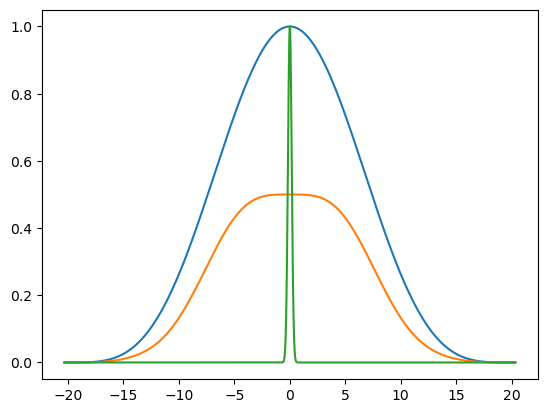

In [ ]:
plt.figure()
plt.plot(time_ary*1e9, proton_sig_1)
plt.plot(time_ary*1e9, proton_sig_2)
plt.plot(time_ary*1e9, electron_sig)
plt.show()

In [ ]:
# --- Make Electron Pulse Train
e_pulse_train = create_pulse_train(eRF1, electron_sig, time_ary, 3, pad_train=(2,2))
# abs( e_pulse_train[0][1] - e_pulse_train[0][0] )
shift_t = e_pulse_train[0].shape[0]//2
test_pulseTrain_time_ary = e_pulse_train[0] - e_pulse_train[0][shift_t-1]

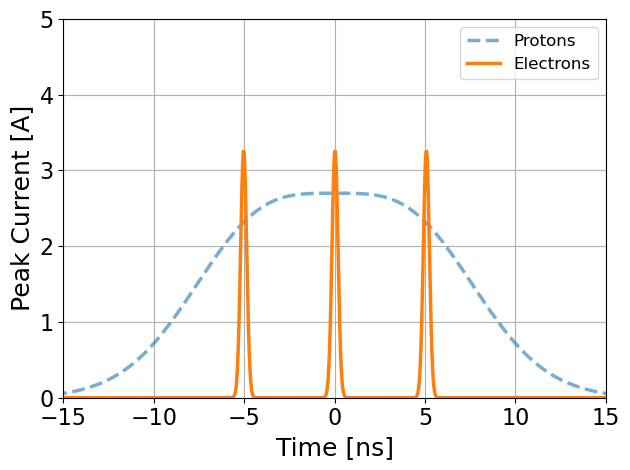

In [ ]:
plt.figure()
plt.plot( time_ary*1e9, 5.4*proton_sig_2, label='Protons', linewidth=2.5, linestyle='--', alpha=0.6)
plt.plot( test_pulseTrain_time_ary*1e9, 3.25*e_pulse_train[1], label='Electrons', linewidth=2.5)

# --- axis settings 
plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [-15, 15] )
plt.ylim( [0.0, 5.0] )
plt.tight_layout()

plt.show()

Good. Now make a pulse train of proton bunchese and electron macrobunches

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 3)

In [ ]:
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 3)

In [ ]:
plt.figure()
plt.plot(p_pulse_train[0]*1e9, p_pulse_train[1])
plt.plot(e_macro_train[0]*1e9, e_macro_train[1])
plt.plot(e_macro_train[0]*1e9, square_wave(e_macro_train[0], pRF1))
plt.show()

#### BUG - Timing not right
Bug... the pulse is coming in much smaller than the period, so I need to add padding to make up the difference

In [ ]:
# --- Debug timing issue with pulse train
# --------------------------------------------------------------

Fs = 1 / (test_pulseTrain_time_ary[1] - test_pulseTrain_time_ary[0])
pulse_period = 1 / pRF1
print("electron_sig size: {}".format(electron_sig.size))

temp = e_pulse_train[1][test_pulseTrain_time_ary > -pulse_period / 2]
print("0.5 * Pulse period: |{}|".format(pulse_period/2))
temp_time_ary = test_pulseTrain_time_ary[test_pulseTrain_time_ary > -pulse_period / 2]
print("Upper - Cut --> temp size: {}".format(temp.size))

temp = temp[temp_time_ary < pulse_period / 2]
print("Lower - Cut --> temp size: {}".format(temp.size))

pulse_ary = np.copy( temp )
print("pulse ary size: {}".format(pulse_ary.size))

In [ ]:
temp_time_ary[-1]-temp_time_ary[0]

In [ ]:
# Check if pulse_time is smaller than pulse_period
if (test_pulseTrain_time_ary[-1] - test_pulseTrain_time_ary[0]) < pulse_period:
    # Calculate the number of samples to zero-pad
    num_zeros = int((pulse_period - (test_pulseTrain_time_ary[-1] - test_pulseTrain_time_ary[0])) * Fs)
    
    # Zero-pad the pulse
    temp_pulse = np.pad(e_pulse_train[1], num_zeros//2, mode='constant')
    
print("temp_pulse size: {}".format(temp_pulse.size))

In [ ]:
# --- create new timing array... 
new_time_ary_linspace = np.linspace( -0.5*pulse_period, 0.5*pulse_period, temp_pulse.size )
print("new_time_ary_linspace size: {}".format(new_time_ary_linspace.size))
new_time_ary_arange = np.arange( -0.5*pulse_period, 0.5*pulse_period, 1/Fs )
print("new_time_ary_arange size: {}".format(new_time_ary_arange.size))


In [ ]:
plt.figure()
plt.plot( test_pulseTrain_time_ary*1e9, e_pulse_train[1] )
plt.plot( new_time_ary_arange*1e9, temp_pulse )
plt.show()

Good... fixed
____
#### Back to testing

In [ ]:
# --- Re - Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 3)

In [ ]:
plt.figure()
plt.plot(p_pulse_train[0]*1e9, p_pulse_train[1])
plt.plot(e_macro_train[0]*1e9, e_macro_train[1])
plt.plot(e_macro_train[0]*1e9, square_wave(e_macro_train[0], pRF1))
plt.show()

Excellent! Now to make it look pretty with fancy plotting. <br><br>
Note: Pulse trains have a full period before and after. Consider making this optional. 

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 5)
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 5)

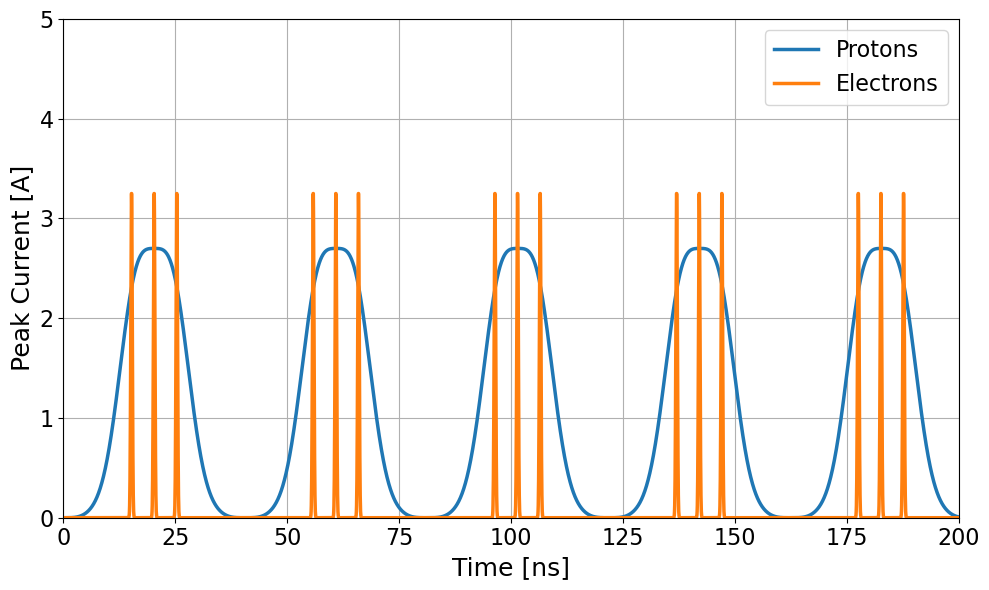

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(p_pulse_train[0] * 1e9, 5.4*p_pulse_train[1], label='Protons',linewidth=2.5)
plt.plot(e_macro_train[0] * 1e9, 3.25*e_macro_train[1], label='Electrons',linewidth=2.5)

plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [0, 200] )
plt.ylim( [0.0, 5.0] )
plt.tight_layout()
plt.show()

In [ ]:
idx = np.argmax( p_pulse_train[1] )
peak_1 = p_pulse_train[0][idx]
peak_2 = p_pulse_train[0][idx+np.argmax( p_pulse_train[1][idx+5:] )]
# peak_2 = np.argmax( p_pulse_train[1][idx+5:] )
print(f"Peak 1: {peak_1*1e9:.2f} ns")
print(f"Peak 2: {peak_2*1e9:.2f} ns")

In [ ]:
# --- Make LEReC Electron Signal
lerec_sigma = 0.02 / const.c  # electron rms bunch length [s]
LEReC_time_ary = np.linspace(-1*(1*0.5)/(9.1e6), 1*0.5/(9.1e6), 1000)  # time array for 1 RF cycle
LEReC_sig, sigma_conf = gaussian_pulse( LEReC_time_ary, sigma=lerec_sigma)
# --- Make LEReC Electron Macro-bunch
LEReC_macro_bunch = create_pulse_train(704e6, LEReC_sig, LEReC_time_ary, 30, pad_train=(2,2))
# --- Make LEReC Pulse Train
LEReC_pulse_train = create_pulse_train((9.1e6), LEReC_macro_bunch[1], LEReC_macro_bunch[0], 5)

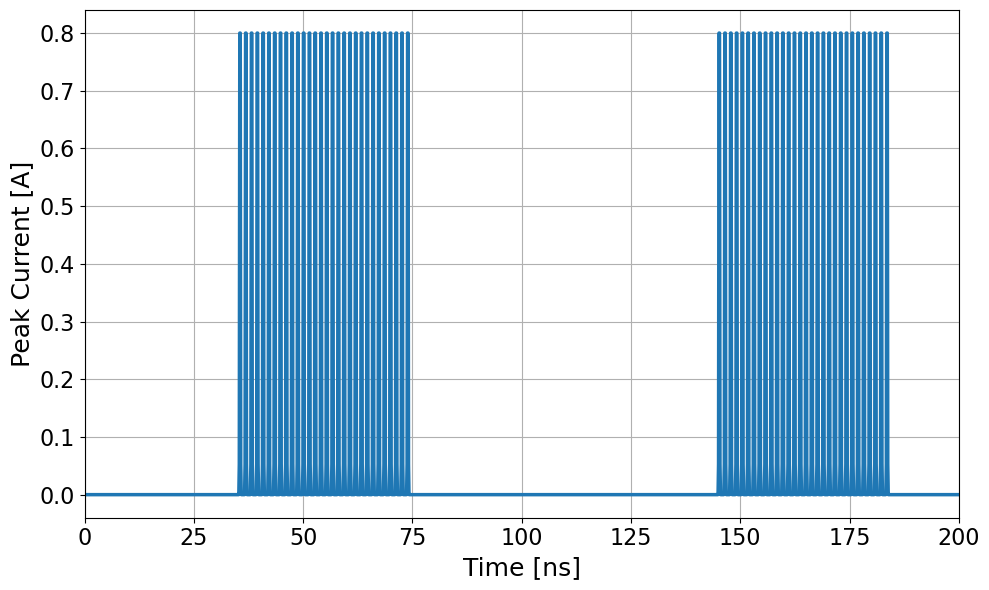

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(LEReC_pulse_train[0] * 1e9, 0.8*LEReC_pulse_train[1], label='Electrons',linewidth=2.5)

plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
# plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [0, 200] )
# plt.ylim( [0.0, 6.0] )
plt.tight_layout()
plt.show()

### Make Spectrum Plots

In [ ]:
num_bunches = 10
time_ary = np.linspace(-1*(num_bunches*0.5)/pRF1, num_bunches*0.5/pRF1, 20000)  # time array for 1 RF cycle
pFs = 1/(time_ary[1] - time_ary[0])

NameError: name 'np' is not defined

In [ ]:
proton_sig_2 = mod_cos_sq_pulse( time_ary, (1/pRF1), pRF2, 1.0, 0.25, 0.0)*0.5

# --- Proton Spectrum
PS2_freq, PS2_spec = get_spectrum( proton_sig_2, pFs )

In [ ]:
# --- Make Electron Signal
electron_sig, e_sigma_confirm = gaussian_pulse( time_ary, sigma=e_sigma)
# --- Make Electron Pulse Train
e_pulse_train = create_pulse_train(eRF1, electron_sig, time_ary, 3, pad_train=(2,2))
emb_Fs = 1/(e_pulse_train[0][1] - e_pulse_train[0][0])
# --- Electron Spectrum
e_freq, e_spec = get_spectrum( electron_sig, pFs )
emb_freq, emb_spec = get_spectrum( e_pulse_train[1], emb_Fs )

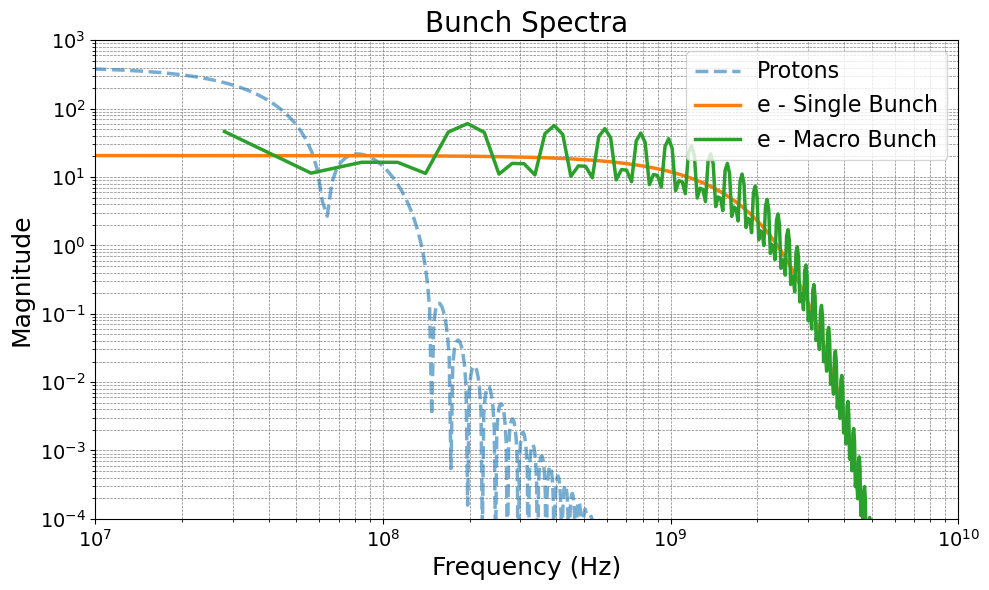

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(PS2_freq[PS2_freq>0], np.abs(PS2_spec[PS2_freq>0]), label='Protons', linewidth=2.5, linestyle='--', alpha=0.6)
ax.plot(e_freq[e_freq>0], np.abs(e_spec[e_freq>0]), label='e - Single Bunch',linewidth=2.5)
ax.plot(emb_freq[emb_freq>0], np.abs(emb_spec[emb_freq>0]), label='e - Macro Bunch',linewidth=2.5)
# --- 
ax.set_xlim(1e7, 1e10)
ax.set_ylim(1e-4, 1e3)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 5, pad_train=(2,2))
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 5, pad_train=(2,2))

In [ ]:
# --- Bunch Train Spectra
pt_FS = 1 / (p_pulse_train[0][1]-p_pulse_train[0][0])
et_FS = 1 / (e_macro_train[0][1]-e_macro_train[0][0])

pt_freq, pt_spec = get_spectrum( p_pulse_train[1], pt_FS )
et_freq, et_spec = get_spectrum( e_macro_train[1], et_FS )

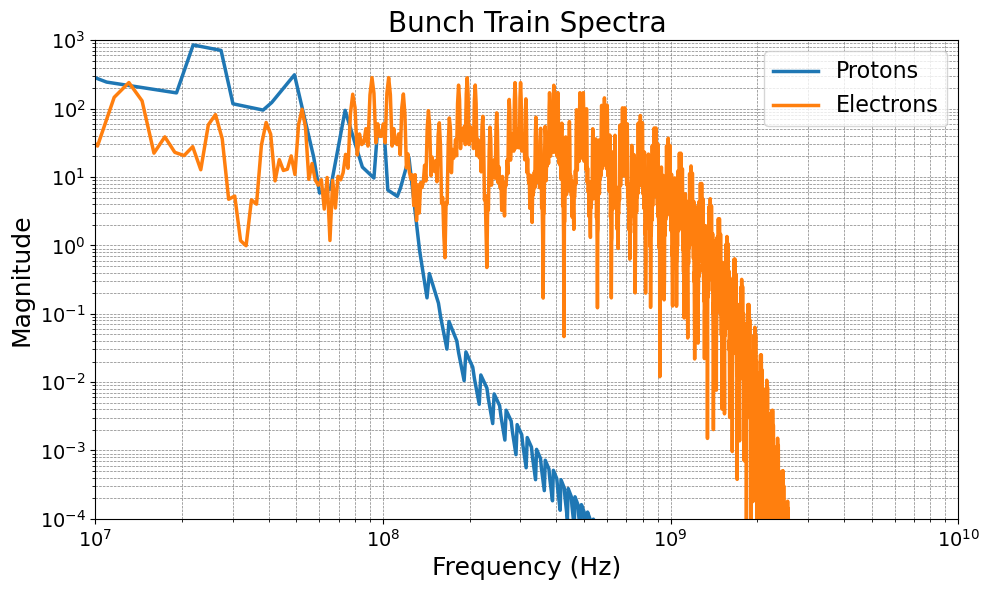

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pt_freq[pt_spec>0], np.abs(pt_spec[pt_spec>0]), label='Protons',linewidth=2.5)
ax.plot(et_freq[et_freq>0], np.abs(et_spec[et_freq>0]), label='Electrons',linewidth=2.5)
# --- 
ax.set_xlim(1e7, 1e10)
ax.set_ylim(1e-4, 1e3)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Train Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Wall Current Monitor Simulation
The goal is to create an RLC simulation of a wall current monitor

In [2]:
# --- RHIC WCM Circuit
wcm_ntwk = simple_wcm_circuit( Cb=65.17e-12, Cc=700e-12, Cp=0.15e-12*50, Ls=0.845e-9/50, Lby=233.56e-6, Rp=75/50 )

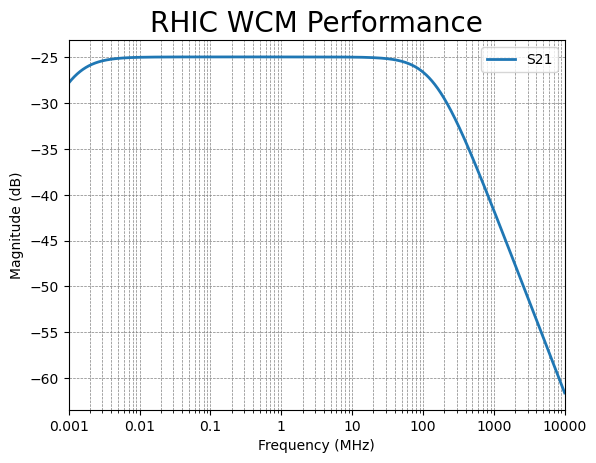

In [11]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
plt.title("RHIC WCM Performance", fontsize=20)
plt.show()

In [24]:
test = wcm_ntwk.s21_db.to_dataframe()

In [25]:
test.head()

,s_db 11
1000.000000,-27.798304
1000.322414,-27.796955
1000.644932,-27.795607
1000.967554,-27.794259
1001.290279,-27.792911


In [19]:
def measure_3db_bandwidth( ntwk ):
	freq = ntwk.f
	magnitude_db = ntwk.s21_db
	
	max_db = np.max(magnitude_db)
	threshold = max_db - 3
	
	# Find where the magnitude crosses the -3 dB line
	indices = np.where(magnitude_db >= threshold)[0]

	if len(indices) < 2:
		return 0.0  # Cannot determine bandwidth

	f_low = freq[indices[0]]
	f_high = freq[indices[-1]]
	return f_high - f_low

In [20]:
measure_3db_bandwidth( wcm_ntwk )

KeyboardInterrupt: 

In [6]:
# --- RHIC WCM Circuit
# --- --- Using the 
freq = rf.Frequency( start=0.001, stop=10000, unit="MHz", npoints=50001, sweep_type='log' )
wcm_media = rf.DefinedGammaZ0( freq, z0=50, gamma=1j*freq.w/rf.c )
Cbr = wcm_media.capacitor( 80e-12, name="Cbr")
Cring = wcm_media.capacitor( 1.418e-15, name="Cring")
EPC = wcm_media.capacitor( 12e-12, name="EPC")
RLs = wcm_media.inductor( 200e-12, name="RLs" )
RLp = wcm_media.inductor( 41.7e-3, name="RLp" )
Llf = wcm_media.inductor( 68.7e-6, name="Llf" )
RWCM = wcm_media.resistor( 1.5, name="RWCM" )
gnd = rf.Circuit.Ground( freq, name="gnd" )
port1 = rf.Circuit.Port( freq, name="port1", z0=50 )
port2 = rf.Circuit.Port( freq, name="port2", z0=50 )

In [7]:
cnx = [
    [(port1,0),(Llf,0),(Cbr,0),(Cring,0), (EPC,0), (RLs,0), (RLp,0),(port2,0)],
    [(RLs,1), (RWCM,0),],
    [(gnd,0),(Llf,1),(Cbr,1),(Cring,1), (EPC,1), (RWCM,1), (RLp,1),]
]

In [8]:
cir = rf.Circuit(cnx)
ntw = cir.network

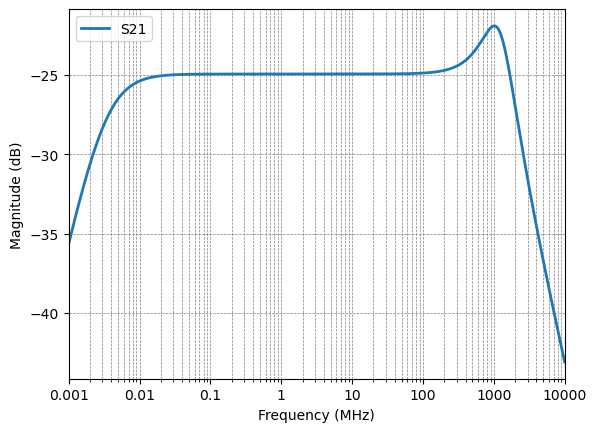

In [9]:
#ntw.plot_s_db( m=0, n=0, lw=2, logx=True )
ntw.plot_s_db( m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
plt.show()

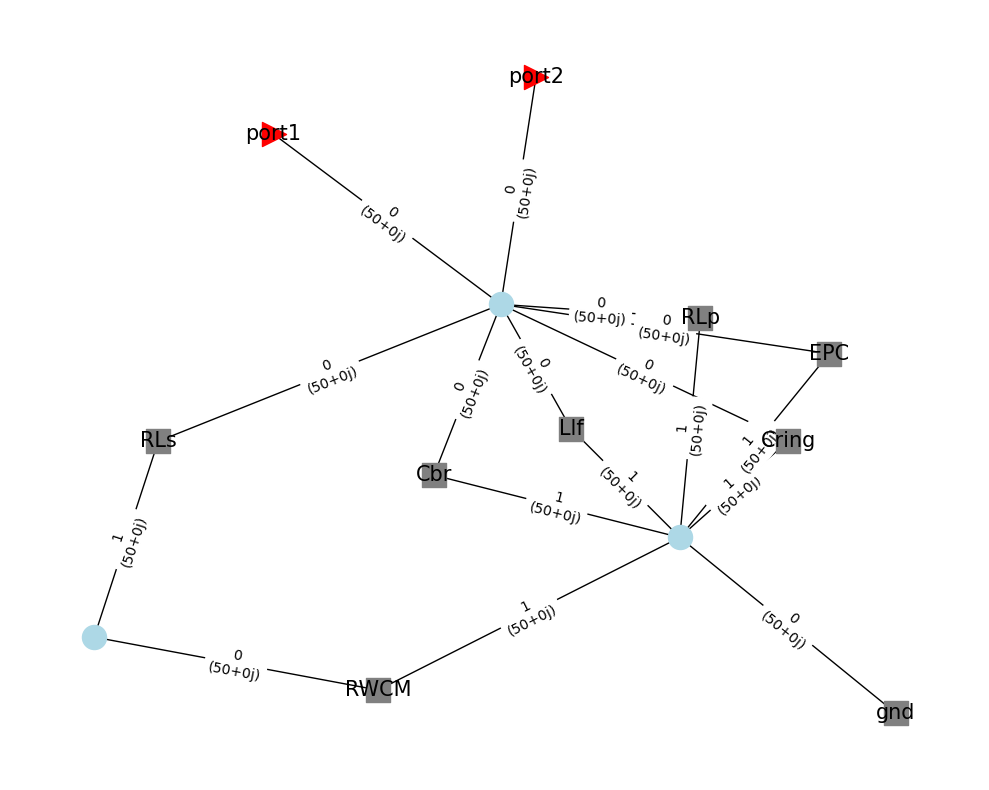

In [18]:
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
              edge_labels=True, edge_fontsize=10)
plt.show()

C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_41084\3581606193.py:2: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit( )


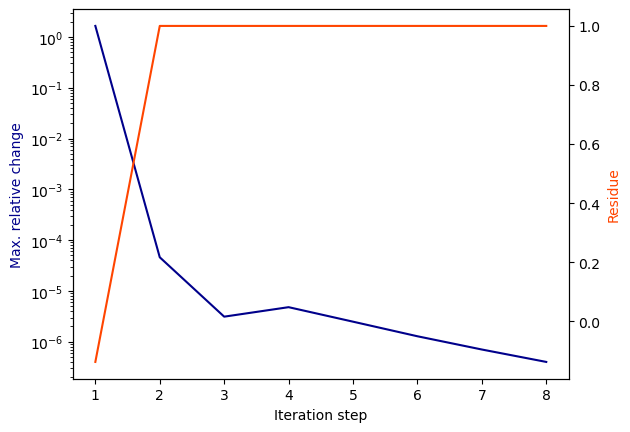

In [58]:
vf = rf.VectorFitting( ntw )
vf.vector_fit( )
vf.plot_convergence()
plt.show()

In [59]:
vf.get_rms_error()

3.1772877731842184e-14

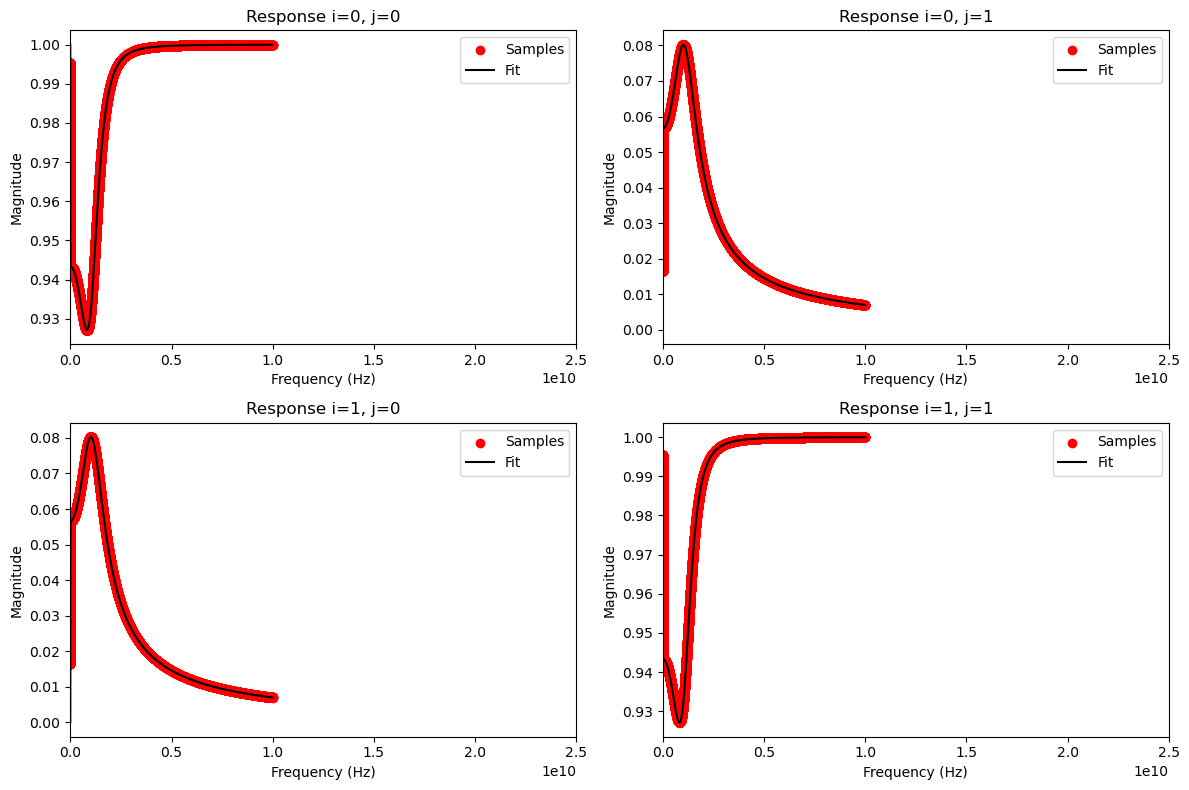

In [60]:
freqs1 = np.linspace(0, 10e9, 1001)
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 8)
vf.plot_s_mag(0, 0, freqs1, ax=ax[0][0]) # plot s11
ax[0][0].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(1, 0, freqs1, ax=ax[1][0]) # plot s21
ax[1][0].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(0, 1, freqs1, ax=ax[0][1]) # plot s12
ax[0][1].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(1, 1, freqs1, ax=ax[1][1]) # plot s22
ax[1][1].set_xlim([0.0, 0.25e11])
fig.tight_layout()
plt.show()

In [99]:
vf.write_spice_subcircuit_s( 'E:\\Qucs_Projects\\Tests\\WCM_Circuit.cir' )

__Direct Multiply with S21__

In [102]:
wcm_ntw = ntw.extrapolate_to_dc()
wcm_s21 = wcm_ntw.s[:,1,0]
Sig_s = fft(proton_sig_2)
Sig_s = 2*Sig_s[:proton_sig_2.size//2]

Tp = time_ary[1] - time_ary[0]
Fspec = fftfreq(proton_sig_2.size, Tp)
Fspec = Fspec[:proton_sig_2.size//2]
Fspec_step = Fspec[1] - Fspec[0]

In [103]:
# --- Interpolation and Linearization
Fx = interp1d(Fspec, Sig_s)
Filt = interp1d(wcm_ntw.f, wcm_s21)
Freqx = np.arange(0.0, wcm_ntw.f[-1], Fspec_step)
NSig_s = Fx(Freqx)
Nlc_s21 = Filt(Freqx)

c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


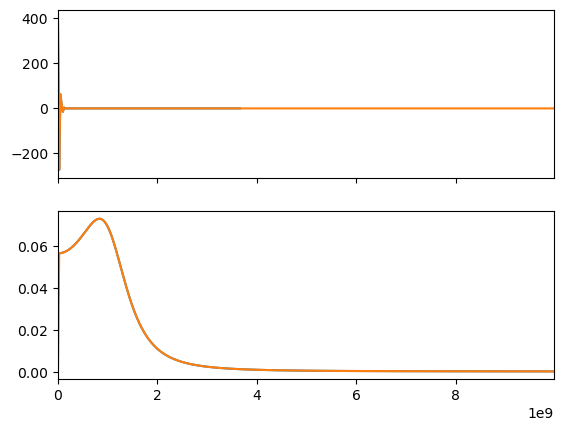

In [105]:
# ---- Check Interpolation
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(Fspec[:150], np.real(Sig_s[:150]))
ax[0].plot(Freqx, np.real(NSig_s) )
ax[0].set_xlim([0.0, Freqx[-1]] )

ax[1].plot(wcm_ntw.f, wcm_s21)
ax[1].plot(Freqx, Nlc_s21)
ax[1].set_xlim([0.0, Freqx[-1]] )
plt.show()

In [107]:
from scipy.fftpack import ifft


In [111]:
Filt_Sig = NSig_s * Nlc_s21 
sig_filt = ifft( Filt_Sig )
#sig_filt *= (sig_filt.size/(Tp*2))
sig_ifft = ifft( Sig_s[:150] ) 

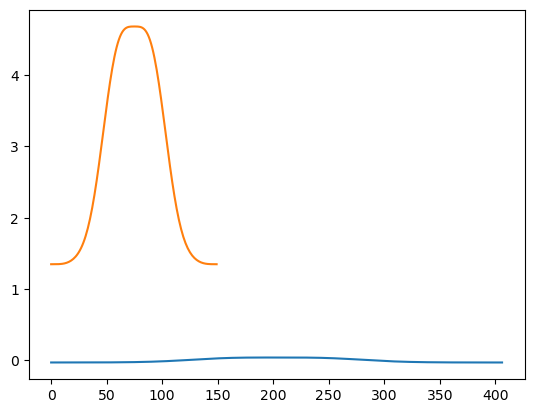

In [113]:
plt.figure()
plt.plot(sig_filt)
plt.plot(sig_ifft)
plt.show()

# test

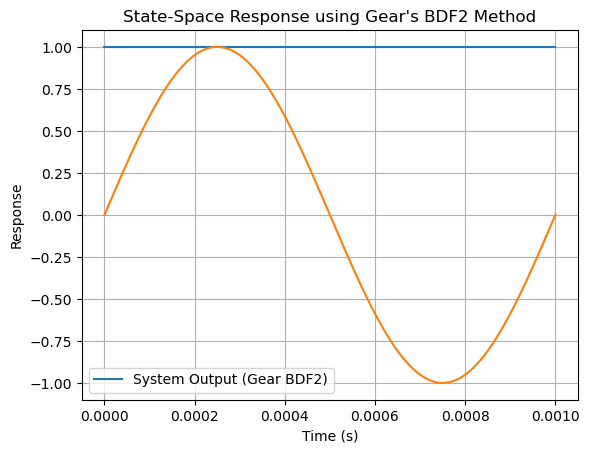

In [157]:
import numpy as np
import matplotlib.pyplot as plt

def gear_bdf2_state_space(A, B, C, D, x0, u, t, h):
    """
    Solve the state-space system using Gear's BDF2 integration.

    Parameters:
        A, B, C, D: State-space matrices.
        x0 : Initial state vector.
        u  : Input signal as an array (length N).
        t  : Time vector.
        h  : Time step.

    Returns:
        y : Output response over time.
    """
    N = len(t)
    state_dim = A.shape[0]
    x = np.zeros((N, state_dim))  # State vector over time
    y = np.zeros(N)  # Output signal

    x[0] = x0  # Set initial condition

    # First step: Use Euler's method for initialization
    x[1] = x[0] + h * (A @ x[0] + B.T * u[0])

    # Gear's BDF2 integration
    for n in range(1, N - 1):
        x[n + 1] = (4/3) * x[n] - (1/3) * x[n - 1] + (2/3) * h * (A @ x[n] + B.T * u[n])

    # Compute output y = Cx + Du
    y = np.array([C @ x[n] + D * u[n] for n in range(N)])

    return y, x

# Example: Define state-space model for an LC circuit
A = np.array([[0, 1], [-1, -0.1]])  # Example system matrix
B = np.array([0, 1]).reshape(-1, 1)  # Input matrix
C = np.array([1, 0]).reshape(1, -1)  # Output matrix
D = np.array([0])  # Direct transmission term

t = np.linspace(0, 1e-3, 1000)  # Time vector
h = t[1] - t[0]  # Time step
x0 = np.array([1, 0])  # Initial condition
u = np.sin(2 * np.pi * 1000 * t)  # Example input (1 kHz sine wave)

# Compute transient response using Gear's method
y_response, x_states = gear_bdf2_state_space(A, B, C, D, x0, u, t, h)

# Plot response
plt.plot(t, y_response, label="System Output (Gear BDF2)")
plt.plot(t, u)
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.title("State-Space Response using Gear's BDF2 Method")
plt.legend()
plt.grid()
plt.show()


In [131]:
x0+h*(A@x0+B*x0)

array([[ 1.000000e+00, -1.001001e-06],
       [ 1.000001e+00, -1.001001e-06]])

In [138]:
N = len(t)
state_dim = A.shape[0]
x = np.zeros((N, state_dim))
x[0] = x0

In [150]:
B*x[0]

array([[0., 0.],
       [1., 0.]])

In [154]:
x[0]+h*(A@x[0]+B.T*x[0])

array([[ 1.000000e+00, -1.001001e-06]])

In [18]:
138*np.log10(2.798/1.2) / 1

50.7379720469294

In [23]:
A = np.pi * abs( (0.0715/2)**2 - (0.090805/2)**2 )
(9.5 * 8.854e-12 * 0.00246 ) / 0.003175

6.517101732283464e-11

In [24]:
calc_ind_cocentric_cylinders( 6500, 0.161925, 0.073787, 0.2286 )

0.00023356882937324524

In [27]:
calc_cap_cocentric_cylinders( 10, 0.161925, 0.073787 )

7.0783705288347e-10

In [28]:
rpc_resistor = import_spram()

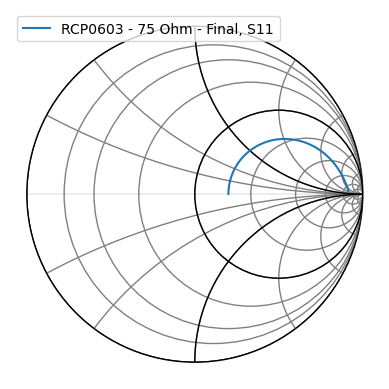

In [30]:
rpc_resistor.plot_s_smith()

In [31]:
# Convert to Z-parameters (input impedance)
z = rpc_resistor.z[:, 0, 0]  # Get Z11 over all frequencies
f = rpc_resistor.f  # Frequency array in Hz

# Calculate series inductance from imaginary part of Z
X = np.imag(z)
L_series = X / (2 * np.pi * f)

# Convert Z to admittance (for parallel capacitance extraction)
y = 1 / z
B = np.imag(y)
C_parallel = -B / (2 * np.pi * f)

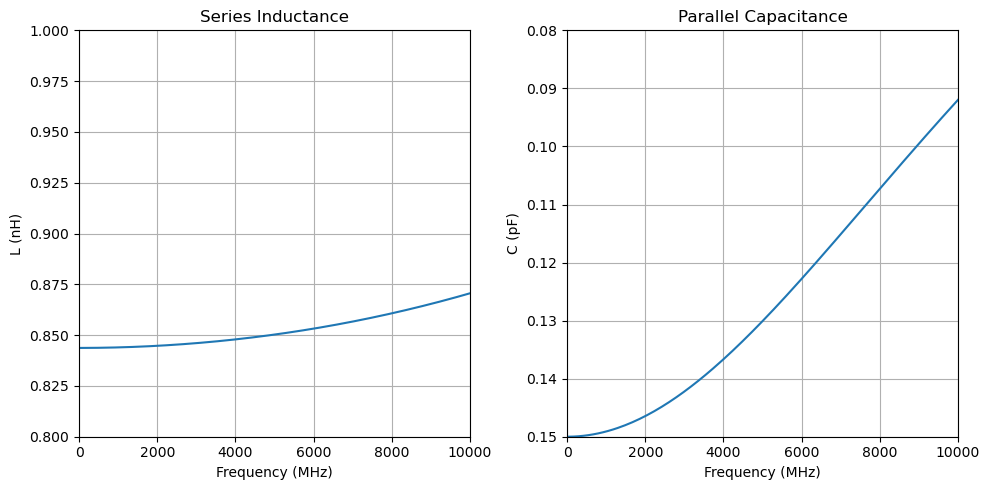

In [34]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(f / 1e6, L_series * 1e9)
plt.grid(True,which='both')
plt.xlim([0, 10000])
plt.ylim([0.8, 1.0])
plt.title("Series Inductance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("L (nH)")

plt.subplot(1, 2, 2)
plt.plot(f / 1e6, C_parallel * 1e12)
plt.grid(True,which='both')
plt.xlim([0, 10000])
plt.ylim([0.15, 0.08])
plt.title("Parallel Capacitance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("C (pF)")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'L (nH)')

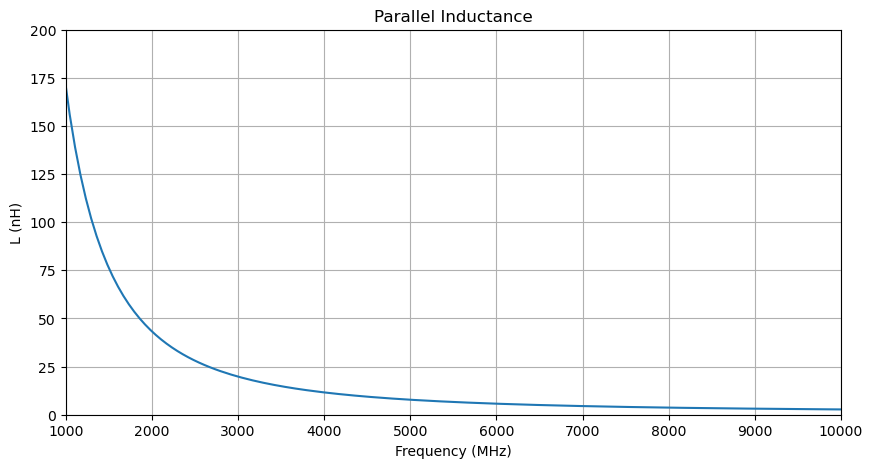

In [44]:
L_parallel = -1 / (2 * np.pi * f * B)

plt.figure(figsize=(10, 5))
plt.plot(f / 1e6, L_parallel * 1e9)
plt.grid(True,which='both')
plt.xlim([1000, 10000])
plt.ylim([0.00, 200])
plt.title("Parallel Inductance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("L (nH)")
